<a href="https://colab.research.google.com/github/raghav2069/Stock-market-prediction-using-CNN/blob/main/Stock_Market_Prediction_with_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url='https://raw.githubusercontent.com/marcopeix/stock-prediction/master/data/stock_prices_sample.csv'
df=pd.read_csv(url)

In [ ]:
def mean_absolute_error(y_true, y_pred):
  err=np.mean(np.abs(y_true-y_pred)/y_true)
  return err

In [ ]:
print(df.shape)
df.head()

(999, 18)


,TICKER,FIGI,DATE,TYPE,FREQUENCY,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,ADJ_FACTOR,EX_DIVIDEND,SPLIT_RATIO
0,GEF,BBG000BLFQH8,2013-01-04,EOD,daily,46.31,47.6198,46.23,47.37,248000.0,38.517220,39.606614,38.450681,39.398849,248000.0,NaN,0.0,1.0
1,GEF,BBG000BLFQH8,2013-01-03,EOD,daily,46.43,46.5200,46.14,46.48,131300.0,38.617027,38.691882,38.375826,38.658613,131300.0,NaN,0.0,1.0
2,GEF,BBG000BLFQH8,2013-01-02,EOD,daily,45.38,46.5400,45.16,46.41,184900.0,37.743715,38.708516,37.560735,38.600392,184900.0,NaN,0.0,1.0
3,GF,BBG000C3C6S2,2018-06-05,Intraday,daily,18.86,18.9100,18.87,18.87,10000.0,18.860000,18.910000,18.870000,18.870000,10000.0,NaN,0.0,1.0
4,GF,BBG000C3C6S2,2018-06-04,EOD,daily,18.86,18.8900,18.79,18.81,39095.0,18.860000,18.890000,18.790000,18.810000,39095.0,NaN,0.0,1.0


In [ ]:
df.TICKER.unique()

array(['GEF', 'GF'], dtype=object)

In [ ]:
df.TYPE.unique()

array(['EOD', 'Intraday'], dtype=object)

In [ ]:
df=df[(df.TYPE=='EOD') & (df.TICKER=='GF')]
df.shape

(995, 18)

In [ ]:
df['DATE']=pd.to_datetime(df['DATE'], yearfirst=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_OHLC=df[['DATE','OPEN','HIGH','LOW','CLOSE']]

In [ ]:
df_ADJ=df.drop(['TICKER','FIGI','TYPE','FREQUENCY','OPEN','HIGH','LOW','CLOSE','VOLUME','ADJ_VOLUME','ADJ_FACTOR','EX_DIVIDEND','SPLIT_RATIO'], axis='columns')

In [ ]:
df_OHLC=df_OHLC.sort_values(by=['DATE'])
df_OHLC=df_OHLC.reset_index(drop=True)
df_OHLC.head(10)

,DATE,OPEN,HIGH,LOW,CLOSE
0,2014-06-23,19.05,19.0500,18.9500,18.9500
1,2014-06-24,18.91,18.9500,18.8300,18.8300
2,2014-06-25,18.66,18.7200,18.5900,18.6000
3,2014-06-26,18.52,18.5901,18.4200,18.5300
4,2014-06-27,18.63,18.6300,18.5100,18.6100
5,2014-06-30,18.68,18.8000,18.5700,18.6701
6,2014-07-01,18.68,18.9200,18.6800,18.8700
7,2014-07-02,18.74,18.8100,18.7201,18.7800
8,2014-07-03,18.86,18.9990,18.8600,18.9000
9,2014-07-07,18.74,18.8299,18.7400,18.7920


Text(0, 0.5, 'ClosingPrice')

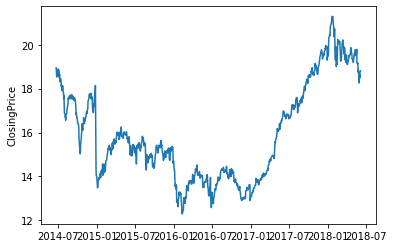

In [ ]:
#Plot Closing Price
plt.plot(df_OHLC.DATE, df_OHLC.CLOSE)
plt.ylabel('ClosingPrice')

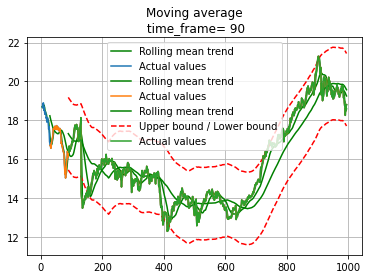

In [ ]:
#Moving Average Smoothing

def plot_moving_average(series, time_frame, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=time_frame).mean()
    
    plt.title('Moving average\n time_frame= {}'.format(time_frame))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        
        mae = mean_absolute_error(series[time_frame:], rolling_mean[time_frame:])
        deviation = np.std(series[time_frame:] - rolling_mean[time_frame:])
        
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        
        
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[time_frame:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(df_OHLC.CLOSE, 5)

#Smooth by the previous month (30 days)
plot_moving_average(df_OHLC.CLOSE, 30)

#Smooth by previous quarter (90 days)
plot_moving_average(df_OHLC.CLOSE, 90, plot_intervals=True)

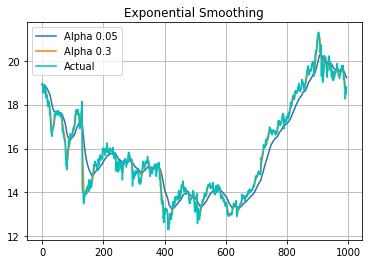

In [ ]:
#Exponential Smoothing

def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):

    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(df_OHLC.CLOSE, [0.05, 0.3])

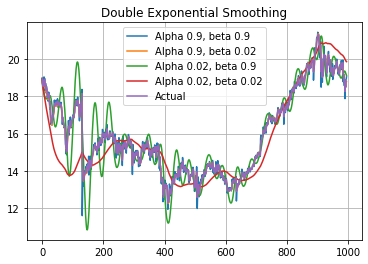

In [ ]:
#Double Exponential Smoothing

def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for i in range(1, len(series)+1):
        if i == 1:
            level, trend = series[0], series[1] - series[0]
        if i >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[i]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(df_OHLC.CLOSE, alphas=[0.9, 0.02], betas=[0.9, 0.02])

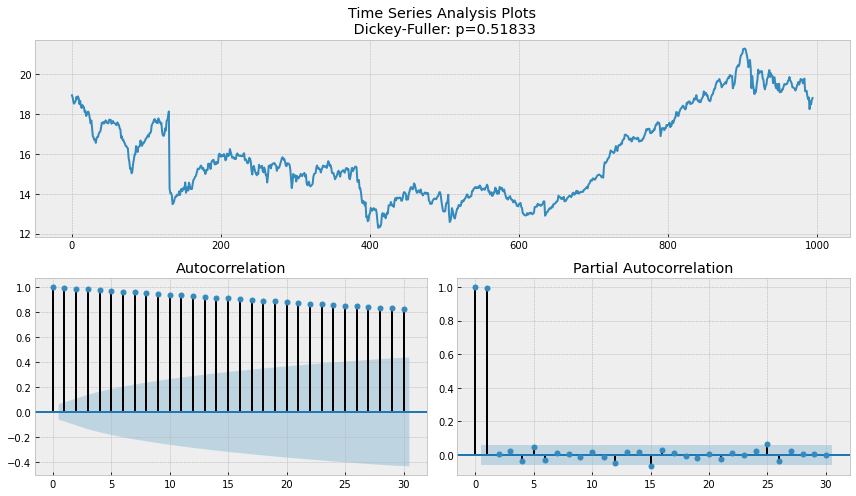

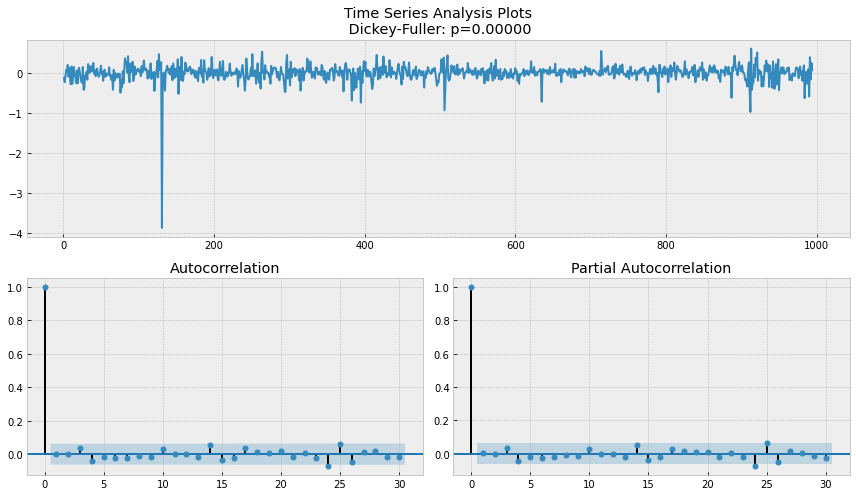

In [ ]:
#Dicky-Fuller test

import statsmodels.tsa.api as smt
import statsmodels.api as sm

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style=style):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(df_OHLC.CLOSE, lags=30)

# Take the first difference to make the process stationary
data_diff = df_OHLC.CLOSE - df_OHLC.CLOSE.shift(1)

tsplot(data_diff[1:], lags=30)

In [ ]:
#SARIMA

from itertools import product
from tqdm import tqdm_notebook
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(df_OHLC.CLOSE, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(df_OHLC.CLOSE, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             CLOSE   No. Observations:                  995
Model:             SARIMAX(0, 1, 0)x(3, 1, 3, 5)   Log Likelihood                 148.874
Date:                           Wed, 25 May 2022   AIC                           -283.748
Time:                                   19:13:45   BIC                           -249.472
Sample:                                        0   HQIC                          -270.714
                                           - 995                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L5       -0.5666      0.145     -3.903      0.000      -0.851      -0.282
ar.S.L10      -0.7984      0.138     -5.795      0.000      -1.068      -0.528
ar.S.L15      -0.0605      0.048     -1.251      0.211      -0.155       0.034
ma.S.L5       -0.4361      0.138     -3.149      0.002      -0.708      -0.165
ma.S.L10       0.2806      0.135      2.081      0.037       0.016       0.545
ma.S.L15      -0.8085      0.133     -6.091      0.000      -1.069      -0.548
sigma2         0.0425      0.001     72.118      0.000       0.041       0.044
===================================================================================
Ljung-Box (Q):                       29.34   Jarque-Bera (JB):            578543.44
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                            -6.74
Prob(H) (two-sided):                  0.00   Kurtosis:                       120.72
===================================================================================


In [ ]:
best_model=sm.tsa.statespace.SARIMAX(df_OHLC.CLOSE, order=(0, 1, 0), seasonal_order=(3, 1, 3, 5)).fit(disp=-1)

In [ ]:
pred=best_model.get_prediction(start=-10) #Prediction for the Last 10 days in the dataset
pred.predicted_mean

985    19.161347
986    19.151464
987    19.162748
988    18.956827
989    18.751228
990    18.815027
991    18.266787
992    18.621945
993    18.532800
994    18.749633
dtype: float64

In [ ]:
forecast=best_model.get_forecast(steps=30) #forecast for the next 30 days
forecast.predicted_mean

995     18.832239
996     18.845624
997     18.824319
998     18.835389
999     18.868475
1000    18.860936
1001    18.870300
1002    18.869256
1003    18.934923
1004    18.906371
1005    18.916905
1006    18.900426
1007    18.877195
1008    18.910358
1009    18.898728
1010    18.886016
1011    18.910401
1012    18.875178
1013    18.897624
1014    18.927847
1015    18.915679
1016    18.937784
1017    18.925844
1018    18.977009
1019    18.973735
1020    18.978725
1021    18.971061
1022    18.956844
1023    19.002257
1024    18.983527
dtype: float64

No handles with labels found to put in legend.


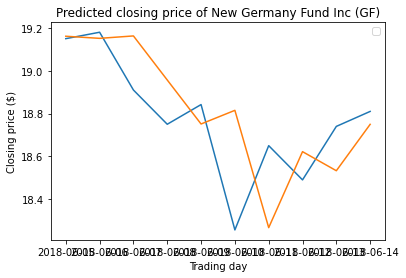

In [ ]:
# Make a dataframe containing actual and predicted prices
comparison = pd.DataFrame({'actual': np.array(df_OHLC.CLOSE[985:995]),
                          'predicted':np.array(pred.predicted_mean)}, 
                          index = pd.date_range(start='2018-06-05', periods=10))


#Plot predicted vs actual price

plt.plot(comparison.actual)
plt.plot(comparison.predicted)
plt.title('Predicted closing price of New Germany Fund Inc (GF)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.legend(loc='best')
plt.grid(False)
plt.show()